In [1680]:
# https://www.kaggle.com/datasets/michaelbryantds/cpu-and-gpu-product-data

### Análise e Entendimento do Problema:

#### Especificação do objetivo geral e dos objetivos específicos

O Objetivo geral do projeto é identificar a relação entre a quantidade dos transistors presentes nos processadores e qual a influência que o tamanho, TDP, entre outras características tem sob o processamento. Dentre os objetivos específicos está o tratamento das informações removendo os outliers, padronizando os dados, analisando as alterações, entre outros.

### a. Especificação do tipo de problema: Quanto à Supervisão, Quanto à Tarefa, Quanto ao Modo;

À FAZER 


b. Especificação das Medidas de Desempenho (para Classificação ou Regressão)


Como metódos de desempenho, os principais utilizados no nosso projeto, se tratam de acurácia para a Classicação e erro quadrático médio para Regressão, esses metódos, são extremamente importantes, pois é através deles que é possível observar o quão precisas estão sendo as predições realizadas pela máquina, por serem duas formas diferentes de Aprendizado de máquina supervisionado, cada um possui seu próprio método de desempenho, para a classificação usaremos o principal citado anteriormente, acurácia, se trata de um indicador da performance geral do modelo, contando quantas classificações foram feitas corretamente, para ser calculado, se torna necessário utilizar a Matriz de confusão, identificando os verdadeiros positivos, falso negativos, falso positivos e verdadeiros negativos, através desses dados é possível montar a Matriz e utilizar a formúla VP+VN/VP+VN+FP+FN para assim medir a acurácia do modelo, já para a regressão utilizaremos o erro quadrático médio, esse método carrega como objetivo encontrar a diferença dos valores iniciais com os valores preditos, quanto mais alta a diferença, maior o problema do modelo, pois os valores encontrados não estão sendo precisos, essa média é calculada através da diferença do valor predito para o valor real, o resultado é elevado ao quadrado, fazendo isso para todos os pontos, como já dito, quanto maior o resultado, mais pobre estão sendo as predições.

##### Hipótese

Com o avanço tecnológico e embasados na lei de Moore, observa-se um crescimento exponencial de transistores em unidades de processamento (CPU's & GPU's) em função do tempo. De forma inversamente proporcional, é perceptível a redução do tamanho dos componentes. Neste projeto, utilizando 2 modelos de aprendizado de máquina, regressão linear e KNN (K-ésimo Vizinho mais Próximo), buscamos prever a quantidade de transistores de uma UDP tendo como parâmetros a TDP (Thermal design power) e seu Die Size. 

# Análise de dados:

In [1681]:
import pandas as pd
import numpy as np
import random
import string
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

### Obtenção dos dados

In [1682]:
df = pd.read_csv('chip_dataset.csv', index_col=0)

Excluindo colunas sem utilidade

########### Explicação

In [1683]:
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)

 Selecionando coluna aleatória

In [1684]:
# escolhendo uma coluna aleatoriamente
random.seed(13)
n = random.randrange(0,len(df.columns))
coluna_aleatoria = df.columns[n]
coluna_aleatoria

'TDP (W)'

In [1685]:
df.head()

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD


### Modificação dos Dados para gerar novos desafios

##### Selecionando 3% dos dados

In [1686]:
p_3 = round(df.shape[0] * 3 / 100)
p_3

146

##### Excluindo 3% dos dados aleatoriamente

In [1687]:
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

In [1688]:
# listando alterações
df.loc[reg_exc_index]

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
3016,NVIDIA GeForce 705A,GPU,2013-10-01,40.0,NaN,79.0,292.0,738.0,TSMC,NVIDIA
3209,NVIDIA Tesla K20Xm,GPU,2012-11-12,28.0,NaN,561.0,7080.0,732.0,TSMC,NVIDIA
1170,Intel Core 2 Duo T7800,CPU,2007-09-27,65.0,NaN,143.0,293.0,2600.0,Intel,Intel
739,Intel Pentium 4 511,CPU,2005-01-01,90.0,NaN,109.0,125.0,2800.0,Intel,Intel
4792,NVIDIA CMP 50HX,GPU,2021-01-01,12.0,NaN,754.0,18600.0,1350.0,TSMC,NVIDIA
...,...,...,...,...,...,...,...,...,...,...
2415,NVIDIA GeForce 9650M GT,GPU,2008-08-19,55.0,NaN,121.0,314.0,550.0,TSMC,NVIDIA
1577,AMD Athlon II X2 260u,CPU,2009-10-20,45.0,NaN,117.0,410.0,1800.0,Unknown,AMD
3734,AMD Radeon R5 M230 Rebrand,GPU,2013-03-01,28.0,NaN,56.0,690.0,750.0,TSMC,AMD
471,AMD Phenom II X3 705e,CPU,2009-06-02,45.0,NaN,258.0,758.0,2500.0,Unknown,AMD


##### Alterando 3% dos dados aleatoriamente

In [1689]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [1690]:
# listando indexes que sofrerão alteração na coluna aleatória
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array

In [1691]:
# inserindo alterações na coluna aleatória
colunas_numericas = df.describe().columns

if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

In [1692]:
# listando alterações
df.loc[reg_alter_index]

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
2730,AMD FirePro W7100,GPU,2014-08-12,28.0,297.0,366.0,5000.0,920.0,TSMC,AMD
1188,AMD A4-3300,CPU,2011-09-07,32.0,701.0,228.0,1178.0,2500.0,Unknown,AMD
2720,NVIDIA GeForce GTX 570M,GPU,2011-06-28,40.0,931.0,332.0,1950.0,575.0,TSMC,NVIDIA
1108,Intel Xeon L5520,CPU,2009-03-30,45.0,700.0,263.0,731.0,2266.0,Intel,Intel
1160,AMD A8-7680,CPU,2018-10-26,28.0,821.0,246.0,1178.0,3500.0,Unknown,AMD
...,...,...,...,...,...,...,...,...,...,...
3010,AMD FirePro W2100,GPU,2014-08-12,28.0,359.0,77.0,950.0,630.0,TSMC,AMD
4345,AMD Radeon R7 250,GPU,2013-10-08,28.0,207.0,77.0,950.0,1000.0,TSMC,AMD
1826,AMD Sempron 3000+,CPU,2005-02-15,130.0,722.0,144.0,69.0,1800.0,Unknown,AMD
2840,NVIDIA Quadro P5000,GPU,2016-10-01,16.0,874.0,314.0,7200.0,1607.0,TSMC,NVIDIA


#### Tratamento de registros nulos em colunas descritivas. 
*       Estratégia adotada: exclusão.

In [1693]:
# Exlusão dos registros nulos nas colunas categoricas
colunas_descritivas = [x for x in list(df.columns) if x not in list(df.describe().columns)]
for col in colunas_descritivas:
    df = df[pd.notnull(df[col])]

#### Tratamento de registros duplicados. 
*       Estratégia: exclusão.

In [1694]:
df.duplicated().sum()

108

In [1695]:
df.drop_duplicates(inplace=True)

#### Tratamento de registros nulos em colunas numéricas. 
*       Estratégia adotada: inserção da média.

In [1696]:
df.isnull().sum()

Product                    0
Type                       0
Release Date               0
Process Size (nm)          9
TDP (W)                  727
Die Size (mm^2)          682
Transistors (million)    687
Freq (MHz)                 0
Foundry                    0
Vendor                     0
dtype: int64

In [1697]:
def imputer_mean(coluna):
    df[coluna] = df[coluna].fillna(df[coluna].mean())
    
for col in list(df.describe().columns):
    imputer_mean(col)

#### Divisão (Amostragem Estratificada)

In [1698]:
# A amostragem estratificada classifca a quantidade de transistors em ranks, sendo assim possível realizar a contagem da quantidade de processadores que possuem um range da quantidade 
# de transistors

# < 250:                Rank F
# >= 250 & < 500:       Rank E
# >= 500 & < 1000:      Rank D
# >= 1000 & < 2000:     Rank C
# >= 2000 & < 6000:     Rank B
# >= 6000 & < 15000:    Rank A
# >= 15000 & < 30000:   Rank S 
# > 30000:              Rank S+ 

In [1699]:
df.reset_index(drop=True, inplace=True)

In [1700]:
def amostragem_estratificada(test_set):
    return (test_set['Rank'].value_counts() / len(test_set))*100

In [1701]:
ranges = [0, 250, 500, 1000, 2000, 6000, 15000, 30000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df['Rank'] = pd.cut(df['Transistors (million)'], bins = ranges, labels = tiers)

In [1702]:
df['Rank'].value_counts()

C     1406
F     1365
B      611
D      567
E      483
A      246
S       60
S+       8
Name: Rank, dtype: int64

In [1703]:
# Com base no gráfico é possível concluir que, nesta base de dados, os processadores com menos de 250 transistores são maioria, seguidos pelos de 1000 a 2000.

<AxesSubplot: xlabel='Rank', ylabel='count'>

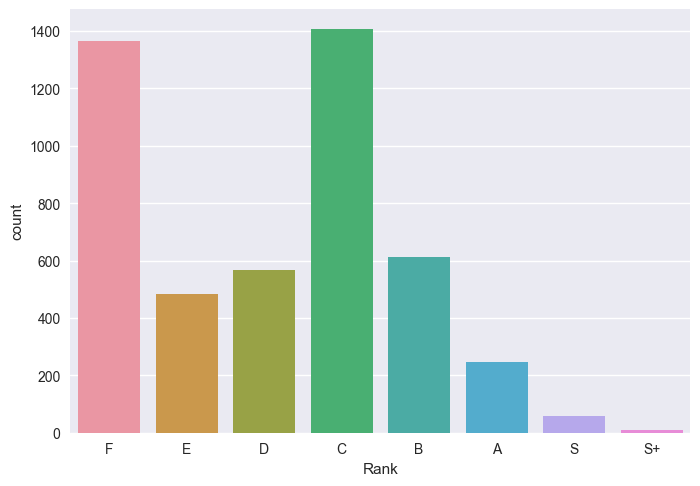

In [1704]:
sns.countplot(x='Rank', data=df, order=tiers)

#### Exploração 

##### Busca de correlações (Coeficientes de correlação)

In [1705]:
colunas_para_calculo = df.describe().columns
print('Coeficiente de correlação de Pearson entre a coluna Die Size (mm^2) e:')

coor_dict = {}
r_list = []

for value in df.corr()['Die Size (mm^2)']:
    if value == 1:
        r = 'relação linear perfeita e positiva'
    elif value == 0:
        r = 'inexistência linear'
    elif value == -1:
        r = 'relação linear perfeita e negativa'
    elif value > 0:
        r = 'relação linear positiva'
    elif value < 0:
        r = 'relação linear negativa'

    r_list.append(r)

print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')

count = 0
for col in colunas_para_calculo: 
    coor_dict[col] = r_list[count]
    print(f'{col}: {coor_dict[col]}')
    count += 1

Coeficiente de correlação de Pearson entre a coluna Die Size (mm^2) e:
Process Size (nm)       -0.383824
TDP (W)                  0.265499
Die Size (mm^2)          0.628311
Transistors (million)    1.000000
Freq (MHz)               0.015711
Name: Transistors (million), dtype: float64 

Process Size (nm): relação linear negativa
TDP (W): relação linear positiva
Die Size (mm^2): relação linear perfeita e positiva
Transistors (million): relação linear positiva
Freq (MHz): relação linear positiva


C:\Users\anjos\AppData\Local\Temp\ipykernel_26304\939001549.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\anjos\AppData\Local\Temp\ipykernel_26304\939001549.py:21: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Análise dos dados

In [1706]:
df_an = df.copy()
df_an.set_index('Release Date', inplace=True)
df_an.sort_index(inplace=True)

In [1707]:
df_cpu = df_an[df_an["Type"] == "CPU"]
df_gpu = df_an[df_an["Type"] == "GPU"]

### Análise da quantidade dos transistores x tamanho do núcleo por ano

#### CPU

In [1708]:
fig_transistors = make_subplots()
fig_die = make_subplots()

# Add traces
fig_transistors.add_trace(
    go.Scatter(x= df_an.index, y=df_cpu["Transistors (million)"] ,name= "CPU")
)
# Add figure title
fig_transistors.update_layout(
    title_text="CPU vs Transistors (million) evolution over years"
)
# Set x-axis title
fig_transistors.update_xaxes(title_text="Years")
# Set y-axes titles
fig_transistors.update_yaxes(title_text="<b>Transistors (million)", secondary_y=False)

# Add traces
fig_die.add_trace(
    go.Scatter(x= df_an.index, y=df_cpu["Die Size (mm^2)"] ,name= "CPU")
)
# Add figure title
fig_die.update_layout(
    title_text="CPU vs Die Size (mm^2) evolution over years"
)
# Set x-axis title
fig_die.update_xaxes(title_text="Years")
# Set y-axes titles
fig_die.update_yaxes(title_text="<b>Die Size (mm^2)", secondary_y=False)

fig_transistors.show()
fig_die.show()

#### GPU

In [1709]:
fig_transistors = make_subplots()
fig_die = make_subplots()

# Add traces
fig_transistors.add_trace(
    go.Scatter(x= df_an.index, y=df_gpu["Transistors (million)"] ,name= "GPU")
)
# Add figure title
fig_transistors.update_layout(
    title_text="GPU vs Transistors (million) evolution over years"
)
# Set x-axis title
fig_transistors.update_xaxes(title_text="Years")
# Set y-axes titles
fig_transistors.update_yaxes(title_text="<b>Transistors (million)", secondary_y=False)

# Add traces
fig_die.add_trace(
    go.Scatter(x= df_an.index, y=df_gpu["Die Size (mm^2)"] ,name= "GPU")
)
# Add figure title
fig_die.update_layout(
    title_text="GPU vs Die Size (mm^2) evolution over years"
)
# Set x-axis title
fig_die.update_xaxes(title_text="Years")
# Set y-axes titles
fig_die.update_yaxes(title_text="<b>Die Size (mm^2)", secondary_y=False)

fig_transistors.show()
fig_die.show()

##### Analise de Transistors x Die Size

### Análise - Frequency

In [1710]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Freq (MHz)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Freq (MHz)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Frequency (MHz) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Freq (MHz)</b>", secondary_y=False)

fig.show()

### Análise - Proccess Size

In [1711]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Process Size (nm)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Process Size (nm)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Process Size (nm) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Process Size (nm)</b>", secondary_y=False)

fig.show()

## Pré-processamento dos dados

##### Normalização

In [1712]:
normalizacao_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

##### Full Pipeline

In [1713]:
def full_pipe(dataframe):
    full_pipeline = ColumnTransformer([
            ('num_attr', normalizacao_pipeline, dataframe.describe().columns),
        ])
    
    return full_pipeline.fit_transform(dataframe)   

## Modelos

#### Divisão de conjuntos, treino e teste

In [1714]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df['Rank']):
  train = df.loc[train_index]
  test = df.loc[test_index]

In [1715]:
train.drop(columns=['Rank'], inplace=True)
test.drop(columns=['Rank'], inplace=True)

In [1716]:
x_train = train.drop(['Transistors (million)', 'Product', 'Type', 'Release Date', 'Foundry', 'Vendor'], axis=1)
y_train = train[['Transistors (million)']].copy()

x_train_prepared = full_pipe(x_train)
y_train_prepared = full_pipe(y_train)

In [1717]:
x_test = train.drop(['Transistors (million)', 'Product', 'Type', 'Release Date', 'Foundry', 'Vendor'], axis=1)
y_test = train[['Transistors (million)']].copy()

x_test_prepared = full_pipe(x_test)
y_test_prepared = full_pipe(y_test)

In [1718]:
test_prepared = full_pipe(test)

### Regressão Linear

In [1719]:
cpu = train.drop(['Transistors (million)', 'Product', 'Type', 'Release Date', 'Foundry', 'Vendor'], axis=1)
cpu_prepared = full_pipe(cpu)
lin_reg = LinearRegression().fit(x_train_prepared, y_train_prepared)
cpu_predictions = lin_reg.predict(x_test_prepared)

##### Curva de treino

In [1720]:
plt.close()
plt.clf()

<Figure size 800x550 with 0 Axes>

In [1721]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LinearRegression(), X = x_train, y = y_train, cv = 10, train_sizes = np.linspace(0.1, 1.0, 10), n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

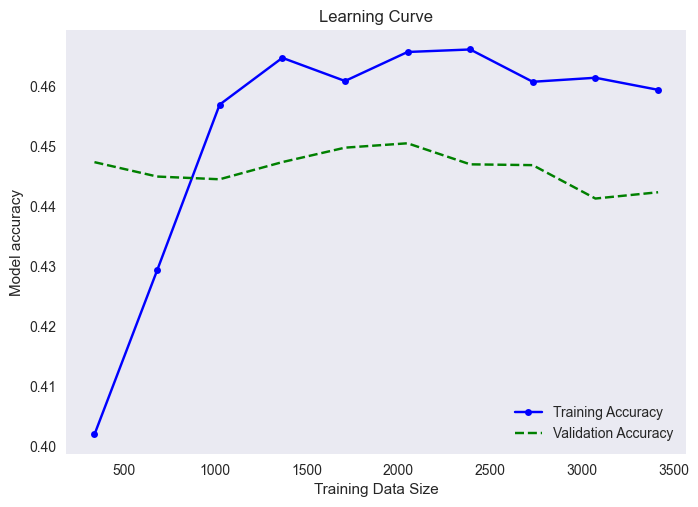

In [1722]:
lr_learning = plt
lr_learning.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
lr_learning.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
lr_learning.title('Learning Curve')
lr_learning.xlabel('Training Data Size')
lr_learning.ylabel('Model accuracy')
lr_learning.grid()
lr_learning.legend(loc='lower right')
lr_learning.show()

In [1723]:
lr_learning.close()

In [1724]:
features = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 'Freq (MHz)'] 
target = 'Transistors (million)'
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = LinearRegression(),
    X = train[features],
    y = train[target], 
    train_sizes = [1, 250, 500, 1000, 2000, 3000], cv = 10, scoring = 'neg_root_mean_squared_error')

In [1725]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

C:\Users\anjos\AppData\Local\Temp\ipykernel_26304\899385337.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



(0.0, 4080.0)

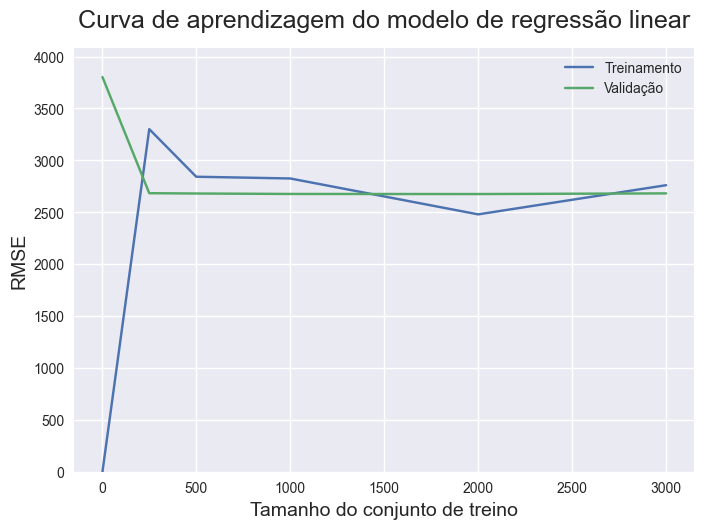

In [1726]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Treinamento')
plt.plot(train_sizes, validation_scores_mean, label = 'Validação')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Tamanho do conjunto de treino', fontsize = 14)
plt.title('Curva de aprendizagem do modelo de regressão linear', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0, 4080)

#### Validação cruzada

In [1727]:
cross_val_score(LinearRegression(), x_train_prepared, y_train_prepared, cv=5)

array([0.42521847, 0.50302762, 0.44411455, 0.45205345, 0.45215317])

#### Avaliação do modelo

##### MAE

In [1728]:
mae = mean_absolute_error(y_test_prepared, cpu_predictions)
round(mae, 2)

0.4

##### RMSE

In [1729]:
lin_rmse = mean_squared_error(y_test, cpu_predictions, squared=False)
round(lin_rmse, 2)

4191.98

##### Regularização 

In [1730]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty="l2", eta0=0.1, random_state=42) # penalty é um regularizador que nao usaremos agora
sgd_reg.fit(x_train_prepared, y_train_prepared.ravel())
sgd_reg.score(x_train_prepared, y_train_prepared.ravel())

0.4313036516635562

#### Grid search

In [1735]:
gs_lin_reg = LinearRegression()
params = {
        "fit_intercept": [True, False], 
        "copy_X": [True, False],
        "n_jobs": [1,-1],
        "positive": [True, False]
}
gs_lin_reg = GridSearchCV(estimator = gs_lin_reg,
                  param_grid= params,
                  cv = 5
                  )

gs_lin_reg.fit(x_train_prepared, y_train_prepared)
print(gs_lin_reg.best_params_)

{'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': False}


### KNN

In [ ]:
x_train = train[['TDP (W)', 'Die Size (mm^2)']]
y_train = train[['Transistors (million)']]

x_train_prepared = full_pipe(x_train)
y_train_prepared = full_pipe(y_train)

In [ ]:
x_test = test[['TDP (W)', 'Die Size (mm^2)']]
y_test = test['Transistors (million)']

x_test_prepared = full_pipe(x_test)

Escolhendo o valor de K

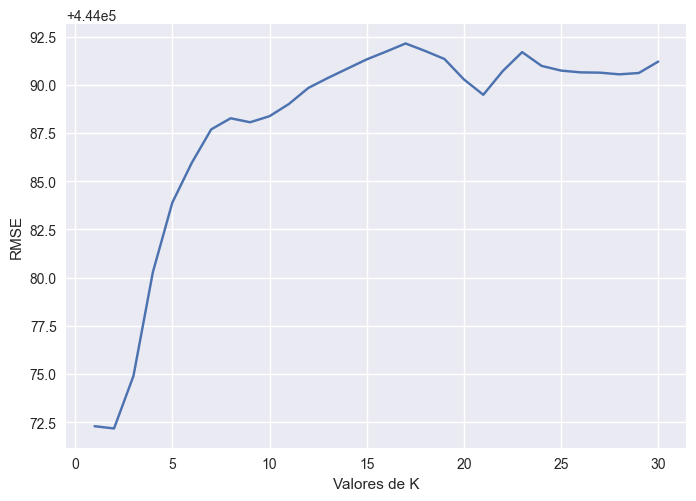

In [ ]:
error = []
for k in range(1, 31):
    knn = KNeighborsRegressor(n_neighbors = k).fit(x_train_prepared, y_train_prepared)
    y_pred = knn.predict(x_test_prepared)
    error.append(mean_squared_error(y_test, y_pred, squared=False) * 100)

k_curve = plt
k_curve.xlabel('Valores de K')
k_curve.ylabel('RMSE')
k_curve.plot(range(1, 31), error)

In [ ]:
k = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, p=1, weights='distance', n_jobs=1)
knn = k.fit(x_train_prepared, y_train_prepared)

In [ ]:
cpu_predictions = knn.predict(x_test_prepared)

##### Curva de treino e validação

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = knn, X = x_train, y = y_train, cv = 10, train_sizes = np.linspace(0.1, 1.0, 10), n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

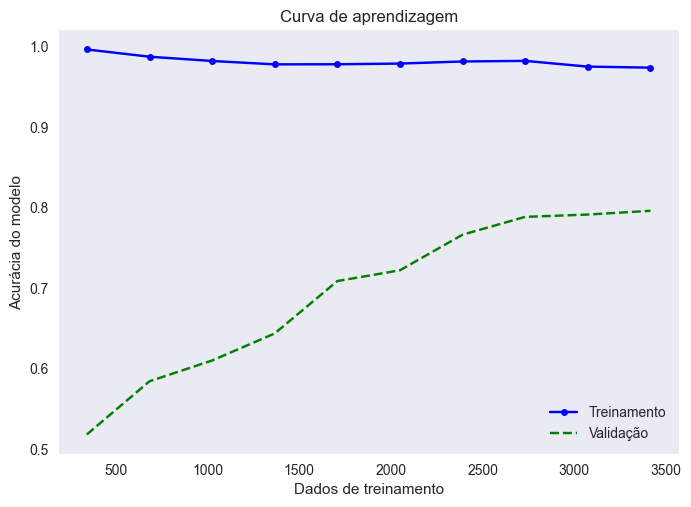

In [ ]:
knn_learning = plt
knn_learning.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Treinamento')
knn_learning.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validação')
knn_learning.title('Curva de aprendizagem')
knn_learning.xlabel('Dados de treinamento')
knn_learning.ylabel('Acurácia do modelo')
knn_learning.grid()
knn_learning.legend(loc='lower right')
knn_learning.show()

#### Validação cruzada 

In [ ]:
cross_val_score(knn, x_train_prepared, y_train_prepared, cv=5)

array([0.73019579, 0.81885425, 0.90658276, 0.79905464, 0.64712948])

#### Avaliação do modelo

##### RMSE

In [ ]:
round(mean_squared_error(y_test, cpu_predictions, squared=True))

19721174

##### MAE

In [ ]:
mae = mean_absolute_error(y_test, cpu_predictions)
round(mae, 2)

1967.96

#### Randomized Search

In [ ]:
params = {'n_neighbors': k, 
           'weights': ['uniform','distance'], 
           'p': [1, 2],
           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [ ]:
k = list(range(1, 31))
random_search = RandomizedSearchCV(
    estimator=KNeighborsRegressor(), 
    param_distributions=params, 
    cv=5)

random_search.fit(x_train, y_train)

str(round(random_search.score(x_train, y_train), 2) * 100) + '%'

'97.0%'

#### Grid Search

In [ ]:
model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=[params], cv=5)
model.fit(x_train_prepared, y_train_prepared)
print(model.best_params_)

{'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 1, 'weights': 'distance'}
